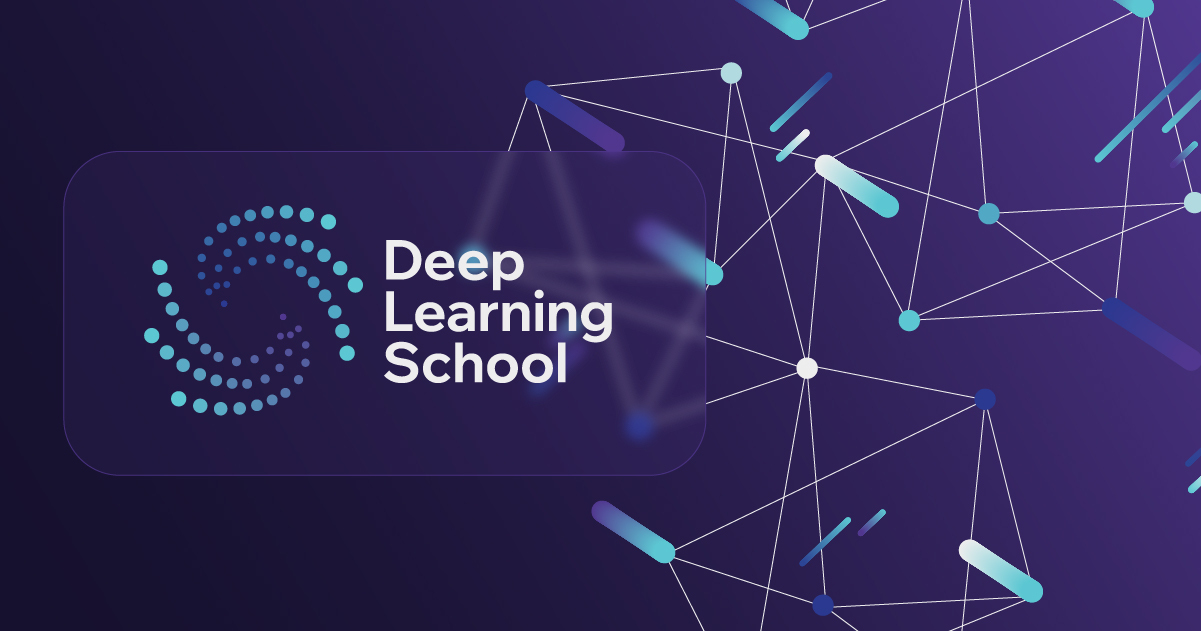

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h1>



В этом занятии нам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.

Для каждого датасета мы будет реализовывать стандартную логику обучения моделей:
1. Подготовим данные
2. Создадим модель (напишем класс модели)
3. Создадим функции обучения на тренировочных данных и применения модели к тестовым данным
4. Проведем обучение, оценим результаты работы моделей

Начнем с импорта необходимых библиотек

In [16]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import random
from tqdm.notebook import tqdm

import copy

sns.set(style="darkgrid", font_scale=1.4)

In [17]:
# Reduce stochasticity

SEED = 42

# PyTorch
torch.manual_seed(SEED)

# CUDA (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups

# NumPy
np.random.seed(SEED)

# Python's built-in random
random.seed(SEED)

In [18]:
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

# Часть 1. Датасет moons


## Часть 1.1. Подготовка данных
Давайте сгенерируем датасет и посмотрим на него!

In [19]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

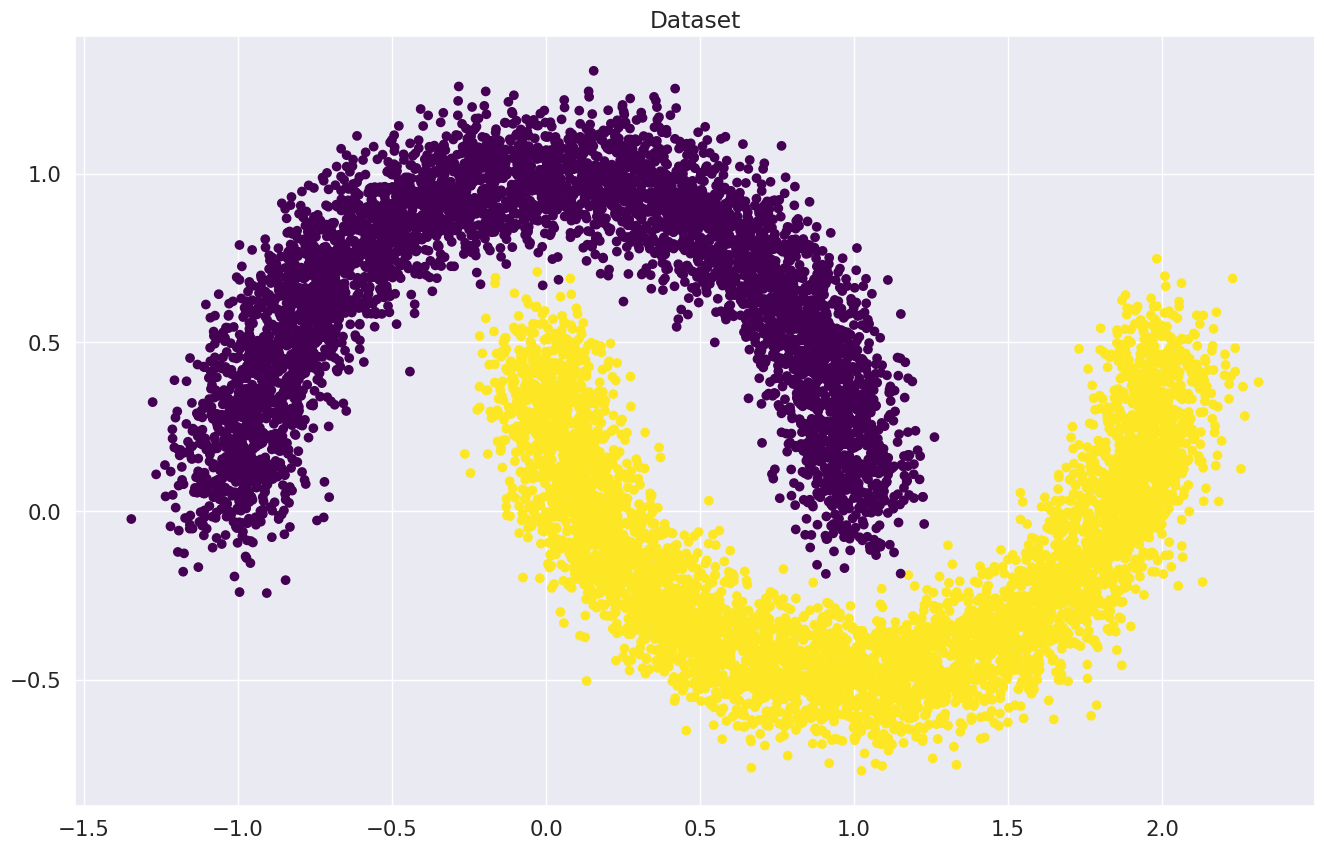

In [20]:
# Визуализация данных

plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Задание. Загрузчики данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

Создайте тензоры с обучающими и тестовыми данными

In [22]:
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_val_t = torch.from_numpy(X_val).float()
y_val_t = torch.from_numpy(y_val).float()

Создаем `Dataset` и `DataLoader`.

Подумайте, нужно ли использовать `shuffle` для:


*   train data
*   validation data

Почему вы приняли такое решение?





Данные, на которых мв тренеруем модель нужно перемешивать так, чтобы модель не зависила от порядка данных. На валидационном датасете уже не надо перемешивать, чтобы можно было легко сравнить предсказания модели с таргетами.

In [23]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle = False)

## Часть 1.2. Класс модели
**Напоминание.** Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак $X$ и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно, на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к классу 1, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоиды берут:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

Модель логистической регрессия - это по сути **нейронная сеть**  с одним линейным слоем и функцией активации сигмоида. Обученная модель возвращает прогнозы вероятностей классов для каждого обхекта, по которым можно рассчитать наиболее вероятный класс для каждого объекта.

В первой части задания мы на этой знакомой нам модели потренируем технику работы с нейронными сетями.

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch, реализующий линейную модель для расчета $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [24]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  torch.matmul(x, self.weights)
        if self.bias:
            x += self.bias_term
        return x

Обартите внимание, что мы предлагаем использовать [BCEWithLogitsLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html), которая работает непосредственно с логитами, в отличие от [BCELoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), куда мы передаём уже значения вероятностей (после операции `sigmoid`).


In [25]:
linear_regression = LinearRegression(in_features = 2, out_features = 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

**Ответ:**

In [26]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[0.3367],
         [0.1288]], requires_grad=True),
 Parameter containing:
 tensor([0.2345], requires_grad=True)]

Суммарное количество отдельных числовых переменных - 3

## Часть 1.3. Функции для работы с моделью (обучение и предсказание)

### Задание. Функция обучения

Перейдём непосредственно к обучению.

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обнуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy`.

Реализуем цикл обучения в виде функции, которая будет принимать в качестве параметров нашу модель, данные (созданный ранее DataLoader), оптимизатор и функцию потерь и проводить обучение (т.е. пересчитывать и обновлять веса модели) до выполнения определенных условий. Функция будет возвращать список из лоссов на всех батчах в цикле обучения и список из наборов всех значений параметров модели (weights и bias_term) по всем эпохам цикла обучения.

Значения параметров мы будем сохранять на случай, если модель переобучится и будут нужны не последние значения, а более старые. Можно было бы сохранять значения параметров не по всем, а по нескольким последним эпохам, но для простоты сохраним по всем эпохам.

Цикл обучения будет остановливаться при выполнении одного из двух условий:
- достижение максимального количества эпох
- замедление снижения валидационной метрики (например, чтобы модель не переобучилась).

Поскольку пока мы с вами еще не определились с метрикой, давайте следить за изменением `loss` (остановка цикла, если разность между усредненными значениями loss в текущей и предыдущей эпохах меньше определенного порога)

Максимальное количество эпох и порог, с которым будем сравнивать разницу усредненных значений loss между эпохами, мы также будем передавать в функцию в качестве параметров.  

**Комментарий**

Следить и сравнивать изменение `train loss` может не всегда корректно отображать ситуацию с обучением. Например, иногда в диффузионных моделях при обучении функция потерь довольно быстро начинает колебаться в окресности одного значения, однако качество генерации картинок еще долго может улучшаться. Однако в данном примере можно использовать прекращение изменения лосса как критерий остановки.

In [27]:
# выход по лоссу
def train_model(model, train_dataloader, optimizer, loss_func, max_epochs, tol = 1e-3):
  '''
  args:
    model - модель для обучения
    train_dataloader - loader с обучающей выборкой
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`
    max_epochs - максимальное количество эпох обучения
    tol - порог, с которым будет сравниваться изменение loss, усредненного по эпохе
  '''

  # создадим переменные (на данный момент - пустые списки), куда будем сохранять
  # лоссы по батчам, усредненные по эпохе лоссы и параметры модели
  batch_losses = []
  epoch_mean_losses = []
  model_param_dict = []

  for epoch in range(max_epochs):
    losses = []    # переменная losses - список, куда будем добавлять значения loss по каждому батчу текущей эпохи
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        # Далее далее по коду идут стандартные операции цикла обучения:
        optimizer.zero_grad()

        outp = model(X_batch)
        outp = outp.squeeze()
        loss = loss_func(outp, y_batch)
        loss.backward()

        losses.append(loss.item())
        optimizer.step()

        # Для расчета accuracy вычисляем вероятности и предсказание класса нашей моделью,
        # затем вычисляем среднее значение accuracy для текущего батча
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.float32)
        batch_acc = (preds == y_batch).sum() / y_batch.size(0)

        # через каждые 100 батчей выводим среднее значение accuracy по батчу
        if (epoch * len(train_dataloader) + it + 1) % 100 == 0:
            print(f"Iteration: {epoch * len(train_dataloader) + it + 1}\nBatch accuracy: {batch_acc}")

    batch_losses = batch_losses + losses    # добавляем список лоссов текущей эпохи к списку лоссов по батчам всех предыдущих эпох
    epoch_mean_losses.append(sum(losses)/len(losses))    # вычисляем средний по текущей эпохе лосс и добавляем к списку по предыдущим эпохам
    model_param_dict.append(copy.deepcopy(model.state_dict()))    # добавляем в список текущие значения параметров модели

    # Ниже реализован ранний выход из цикла обучения. Если разница между средним по эпохе значением loss в текущей
    # и предыдущей эпохах меньше порога tol, то оператор return завершит выполнение функции и обучение прекратится
    if epoch > 0 and abs(epoch_mean_losses[-1] - epoch_mean_losses[-2]) < tol:
          print(f"\nIteration: {epoch * len(train_dataloader) + it +1}. Convergence. Stopping iterations after {epoch + 1} epochs.")
          return batch_losses, model_param_dict

  return batch_losses, model_param_dict

Теперь давайте проверим нашу функцию. Запустим обучение с лимитом 100 эпох.

**Замечание.** Если вы захотите запустить обучение модели заново, не забудьте снова инициировать модель и оптимайзер. Если этого не сделать, функция train_model() будет пытаться обновлять веса уже обученной ранее модели - то есть пытаться дообучить нашу модель. Если же мы сначала заново инициируем модель, ее веса обновятся на случайные значения (см. строки self.weights = nn.Parameter(...) и self.bias_term = nn.Parameter(...) в функции инициализации `__init__()`) и обучение будет происходить с нуля.

  

In [32]:
#При повторном запуске функции train_model() заново инициируйте модель и оптимайзер.
#Для этого раскомментируйте соответствующий код ниже:

linear_regression = LinearRegression(2, 1)
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)
# linear_regression = LinearRegression(2, 1)
# optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)
losses, model_param_dict = train_model(model = linear_regression,
                                       train_dataloader = train_dataloader,
                                       optimizer = optimizer,
                                       loss_func = loss_function,
                                       max_epochs=100, tol = 1e-3)

ValueError: Target size (torch.Size([128])) must be the same as input size (torch.Size([128, 1]))

In [ ]:
# Если вы захотите посмотреть на значения весов обученной модели, раскомментируйте код ниже

#Вариант 1 - вручную, в рамках работы с классами в ООП:
#print(linear_regression.weights)
#print(linear_regression.bias_term)

#Вариант 2 - с помощью стандартного метода parameters() класса nn.Module
#list(linear_regression.parameters())

#Вариант 3 - с помощью стандартного метода state_dict() класса nn.Module
#linear_regression.state_dict()

**Замечание.** Обратите внимание, при сохранении в список значений параметров модели после обучения на текущей эпохе, мы делали глубокую копию значение параметров:

`model_param_dict.append(copy.deepcopy(model.state_dict()))`

Если просто добавлять в список значения параметров:

`model_param_dict.append(model.state_dict())`, то при продолжении обучения и, соответственно, пересчете параметров, в списке `model_param_dict` будут изменяться значения всех элементов. Вы можете самостоятельно в этом убедиться, если уберете в функции обучения `copy.deepcopy()`, заново проведете обучение модели и выведете список всех параметров модели - значения не будут различаться между эпохами. Импорт модуля `copy` перед определением функции обучения был нужен для использования глубокого копирования.  

Это упражнение не является обязательной частью задания. Если вы его выполните, не забудьте вернуть в код `copy.deepcopy()` и обучить модель с корректной функцией.

**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:**

### Визуализируем результаты

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Применим обученную модель к тестовым данным
Реализуйте функцию predict и посчитайте accuracy на test. Функция должна возвращать предсказание наиболее вероятного класса для каждого объекта из валидационой выборки:

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #YOUR CODE GOES HERE
    return #YOUR CODE GOES HERE

Сравните предсказания наиболее вероятного класса, полученные с помощью функции predict(), с фактическими классами в валидационной выборке и рассчитайте accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
# YOUR CODE. Compute total accuracy

**Вопрос 3**

Какое `accuracy` получается после обучения? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:**

# Часть 2. Датасет MNIST

## Часть 2.1. Подготовка данных
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

### Задание. Загрузчики данных

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset_MNIST = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset_MNIST  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader_MNIST = # YOUR CODE GOES HERE
valid_dataloader_MNIST = # YOUR CODE GOES HERE

# Далее будем использовать словарь из загрузчиков
loaders_MNIST = {"train": train_dataloader_MNIST, "valid": valid_dataloader_MNIST}

## Часть 2.2. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Модель простой полносвязной нейронной сети

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.


In [ ]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
)

Задайте лосс для обучения (кросс-энтропия).

Вспомним, что такое кросс-энтропийная функция потерь:

$$
L = -\frac{1}{N} \sum_{n=1}^{N} \sum_{i=1}^{C} y_{ni} \log(\hat{y}_{ni})
$$

где:
- $N$ — количество объектов в выборке,
- $C$ — количество классов,
- $y_{ni}$ — истинная метка (one-hot представление),
- $\hat{y}_{ni}$ — предсказанная вероятность модели для класса $i$ на примере $n$.

***Пример расчета***

Рассмотрим пример расчета кросс-энтропийной функции потерь для задачи многоклассовой классификации с 10 классами. Предположим, что у нас есть один объект, истинный класс которого известен, а модель выдала свои предсказания в виде вероятностей для каждого класса.

Пусть объект является цифрой 2. Тогда:
     $$
     y = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
     $$

Пусть модель выдала следующие вероятности для 10 классов:  
     $$
     \hat{y} = [0.1, 0.05, 0.6, 0.15, 0.05, 0.02, 0.01, 0.01, 0.01, 0.0]
     $$

$$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$



Только один элемент $y_i$ равен 1, остальные равны 0. Поэтому:

$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i) = - y_2 \cdot log(\hat{y}_2) = - 1 \cdot log(0.6) \approx 0.51
$

In [ ]:
criterion = #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Задание. Функции для обучения и валидации модели

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    model.train()  # <------------------ переводим модель в режим train
    for x_batch, y_batch in train_dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <--------- обнуляем градиенты модели
        outp = model(x_batch)   # <------------- получаем "логиты" из модели
        loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
        loss.backward()  # <--------------- считаем градиенты
        optimizer.step()  # <-------------- делаем шаг градиентного спуска
        count_metrics(outp, y_batch)  # <-------- считаем метрики на train датасете
     
     model.eval()  # <------------------ переводим модель в режим eval
     for x_batch, y_batch in val_dataloader:   #<--------- реализуем режим test/eval
         with torch.no_grad():  # <--------- НЕ считаем градиенты
            outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch) # <-------- считаем метрики на test датасете
        
        
```

Как и ранее обучение модели и проверку на валидационной выборке реализуем через функции. Создадим три функции:
1. для обучения модели на всей обучающей выборке (по всем батчам) на одной эпохе
2. для валидации модели на всей валидационной выборке (по всем батчам) на одной эпохе
3. для запуска функций 1. и 2. циклически по количеству эпох обучения модели

In [ ]:
def fit_one_epoch(model, train_dataloader, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    train_dataloader - loader с выборкой для обучения модели
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`

  функция возвращает метрику accuracy по эпохе на данных из train_dataloader
  '''

  epoch_correct_predictions = 0.0
  epoch_all_predictions = 0.0
  # YOUR CODE. переводим модель в режим train

  for X_batch, y_batch in tqdm(train_dataloader):
    # Далее далее по коду идут стандартные операции цикла обучения:
    # YOUR CODE. обнуляем градиенты модели

    outp = # YOUR CODE. Use model() to get outputs
    loss = # YOUR CODE. Compute loss

    loss.# YOUR CODE. считаем градиенты
    optimizer.# YOUR CODE. делаем шаг градиентного спуска

    # Рассчитаем accuracy. Для этого определим количество верных предсказаний
    # и общее количество предсказаний в каждом батче, а затем накопительным итогом посчитаем
    #  количество верных предсказаний и общее количество предсказаний в рамках эпохи
    preds = outp.argmax(-1)
    batch_correct_predictions = # YOUR CODE GOES HERE
    batch_all_predictions = len(preds)

    epoch_correct_predictions += # YOUR CODE GOES HERE
    epoch_all_predictions += batch_all_predictions

  epoch_accuracy = epoch_correct_predictions/epoch_all_predictions
  return epoch_accuracy

In [ ]:
# проверим работу функции
fit_one_epoch(model = model, train_dataloader = train_dataloader_MNIST, optimizer = optimizer, loss_func = criterion)

In [ ]:
def eval_one_epoch(model, val_dataloader):
  '''
  args:
    model - модель для обучения
    val_dataloader - loader с валидационной/тестовой выборкой
  '''

  epoch_correct_predictions = 0.0
  epoch_all_predictions = 0.0
  # YOUR CODE. Переводим модель в режим eval

  for X_batch, y_batch in tqdm(val_dataloader):
    # Далее далее по коду идут стандартные операции цикла валидации:
    # YOUR CODE. Не забываем отключить расчет градиентов
      # YOUR CODE. Получаем "логиты" из модели
      preds = # YOUR CODE. Определяем нииболее вероятный класс для каждого объекта в батче

    # Рассчитаем accuracy
    batch_correct_predictions = # YOUR CODE GOES HERE
    batch_all_predictions = # YOUR CODE GOES HERE

    epoch_correct_predictions +=  # YOUR CODE GOES HERE
    epoch_all_predictions += # YOUR CODE GOES HERE

  epoch_accuracy = # YOUR CODE GOES HERE
  return epoch_accuracy

In [ ]:
# проверим работу функции
eval_one_epoch(model = model, val_dataloader = valid_dataloader_MNIST)

Ниже представлена функция, с помощью которой мы будем обучать модели. Эта функция вызывает fit_one_epoch() с числом раз, равным количеству эпох. Каждую эпоху также вызывается функция eval_one_epoch() для расчета accuracy на валидационной выборке.

Функция возвращает словарь с accuracy на обучающей и валидационной выборках на каждой эпохе.       

In [ ]:
def train_func(model, num_epochs, dataloaders, optimizer, loss_func):
  '''
  args:
    model - модель для обучения
    num_epochs - количество эпох
    dataloaders - словарь loader'ов с обучающей и валидационной выборками
    optimizer - оптимизатор, взятый из модуля `torch.optim`
    loss_func - функция потерь, взятая из модуля `torch.nn`

  функция возвращает accuracy на обучающей и валидационной выборках на каждой эпохе
  '''

  accuracy = {"train": [], "valid": []}
  for epoch in range(num_epochs):
    print(f"\nEpoch: {epoch+1}")

    accuracy_train_one_epoch = fit_one_epoch(model = model, train_dataloader = dataloaders['train'], optimizer = optimizer, loss_func = loss_func)
    print(f"Accuracy_train: {accuracy_train_one_epoch.item()}\n")

    accuracy_test_one_epoch = eval_one_epoch(model = model, val_dataloader = dataloaders['valid'])
    print(f"Accuracy_test: {accuracy_test_one_epoch.item()}\n")

    accuracy['train'].append(accuracy_train_one_epoch)
    accuracy['valid'].append(accuracy_test_one_epoch)
  return accuracy

In [ ]:
# Заново инициируем модель (для этого запустите код с инициацией в начале части 2.2. задания) и запустим обучение на 10 эпохах
optimizer = torch.optim.Adam(model.parameters())
max_epochs = 10
accuracy = train_func(model = model, num_epochs = max_epochs, dataloaders = loaders_MNIST, optimizer = optimizer, loss_func = criterion)

### Функции активации

Функции активации добавляют ***нелинейность в модель***, что позволяет сети решать сложные задачи, такие как классификация и регрессия. Без функций активации нейронная сеть была бы линейной моделью, так как ***композиция линейных преобразований*** это ***линейное преобразование***.

**ReLU (Rectified Linear Unit)**
   - Формула: $ f(x) = \max(0, x) $
   - Диапазон значений: $ [0, \infty) $

**Leaky ReLU**
   - Формула: $ f(x) = \max(\alpha x, x) $, где $ \alpha $ — маленькое положительное число (обычно $ \alpha = 0.01 $).
   - Диапазон значений: $ (-\infty, \infty) $

**Exponential Linear Unit (ELU)**
   - Формула:
   $f(x) = $
     \begin{cases}
     x & \text{если } x > 0 \\
     \alpha (e^x - 1) & \text{если } x \leq 0
     \end{cases}
   - Диапазон значений:  $ (-\alpha, \infty) $

**Tanh (Гиперболический тангенс)**

  - Формула: $f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
  - Диапазон значений: $(-1, 1)$

**Линейная функция активации**
   - Формула: $ f(x) = x $
   - Диапазон значений: $ (-\infty, \infty) $

   Обратите внимание, что данная функция активации **не добавляет** нелинейности.

#### Задание на дополнительный балл (3 балла)


Давайте попробуем закодировать наши функции активаций, а также потренируемся считать их градиенты.

Напишите классы для каждой из функций активации, а также для градиентов:

1. Leaky ReLU (1.5 балл: 0.5 forward pass, 1 -- backward (grad))

2. Tanh (1.5 балл: 0.5 forward pass, 1 -- backward (grad))

Для того, чтобы было понятнее, что нужно сделать -- приведём пример

In [ ]:
class ReLU(nn.Module):
  def __init__(self, ):
    super().__init__()


  def forward(self, x):
    return torch.maximum(torch.zeros_like(x), x)

  def backward(self, x):
    grads = torch.zeros_like(x)
    grads[x > 0] = 1
    return grads


In [ ]:
# test forward pass

torch_relu = nn.ReLU()
your_relu = ReLU()

x = torch.linspace(-3, 3, 100, requires_grad=True)


x_relu_custom = your_relu(x)
x_relu_torch = torch_relu(x)

assert torch.allclose(x_relu_custom, x_relu_torch)

In [ ]:
grad_relu_custom = your_relu.backward(x)

x_relu_torch.sum().backward()
grad_relu_torch = x.grad.clone()
x.grad.zero_()

assert torch.allclose(grad_relu_custom, grad_relu_torch)

In [ ]:
# Plot custom and torch functions
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Activation Functions Comparison")

# Plot Custom Functions
axes[0].set_title("Activation Functions")
axes[0].plot(x.detach().numpy(), x_relu_custom.detach().numpy(), label="Custom ReLU")
axes[0].plot(x.detach().numpy(), x_relu_torch.detach().numpy(), color='red', label="Torch ReLU", linestyle='--')
axes[0].legend()
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# Plot Torch Functions
axes[1].set_title("Torch Activation Functions Gradients")
axes[1].plot(x.detach().numpy(), grad_relu_custom.detach().numpy(), label="Custom ReLU")
axes[1].plot(x.detach().numpy(), grad_relu_torch.detach().numpy(), color='red', label="Torch ReLU", linestyle='--')
axes[1].legend()
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")

plt.show()

Теперь самостоятельно реализуйте две другие функции активаций.

In [ ]:
class LeakyReLU(nn.Module):
  def __init__(self, alpha):
    super().__init__()
    self.alpha = alpha


  def forward(self, x):
    # YOUR CODE

  def backward(self, x):
    # YOUR CODE

class Tanh(nn.Module):
  def __init__(self, ):
    super().__init__()


  def forward(self, x):
    # YOUR CODE

  def backward(self, x):
    # YOUR CODE




In [ ]:
# lets test your functions with torch functions

torch_leaky_relu = nn.LeakyReLU(negative_slope=0.01)
torch_tanh = nn.Tanh()


your_leaky_relu = LeakyReLU()
your_tanh = Tanh()


In [ ]:
# Test forward pass
x_leaky_custom = your_leaky_relu(x)
x_leaky_torch = torch_leaky_relu(x)

assert torch.allclose(x_leaky_custom, x_leaky_torch)

x_tanh_custom = your_tanh(x)
x_tanh_torch = torch_tanh(x)

assert torch.allclose(x_tanh_custom, x_tanh_torch)


In [ ]:
grad_leaky_custom = your_leaky_relu.backward(x)


x.grad.zero_()
x_leaky_torch.sum().backward()
grad_leaky_torch = x.grad.clone()

assert torch.allclose(grad_leaky_custom, grad_leaky_torch)

grad_tanh_custom = your_tanh.backward(x)

x.grad.zero_()
x_tanh_torch.sum().backward()
grad_tanh_torch = x.grad.clone()


assert torch.allclose(grad_tanh_custom, grad_tanh_torch)


In [ ]:
# Plot custom and torch functions
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Activation Functions Comparison Leaky ReLU")

# Plot Custom Functions
axes[0].set_title("Activation Functions")
axes[0].plot(x.detach().numpy(), x_leaky_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[0].plot(x.detach().numpy(), x_leaky_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[0].legend()
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# Plot Torch Functions
axes[1].set_title("Torch Activation Functions Gradients")
axes[1].plot(x.detach().numpy(), grad_leaky_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[1].plot(x.detach().numpy(),1 grad_leaky_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[1].legend()
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")

plt.show()

In [ ]:
# Plot custom and torch functions
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Activation Functions Comparison Tanh")

# Plot Custom Functions
axes[0].set_title("Activation Functions")
axes[0].plot(x.detach().numpy(), x_tanh_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[0].plot(x.detach().numpy(), x_tanh_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[0].legend()
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")

# Plot Torch Functions
axes[1].set_title("Torch Activation Functions Gradients")
axes[1].plot(x.detach().numpy(), grad_tanh_custom.detach().numpy(), label="Custom Leaky ReLU")
axes[1].plot(x.detach().numpy(), grad_tanh_torch.detach().numpy(), color='red', label="Torch Leaky ReLU", linestyle='--')
axes[1].legend()
axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")

plt.show()

**Вопрос на подумать:**

Какие недостатки есть у активаций `ReLU` и как эту проблему решает `Leaky ReLU`?

Что происходит с градиентами у активации `Tanh` и как это может помешать обучению?

#### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:

# для функции активации ELU() воспользуемся полученной ранее оценкой accuracy
elu_accuracy = accuracy["valid"]

Оценку для остальных функций активации реализуем при помощи функции, которая будет инициировать и обучать модель с необходимой функцией активации:

In [ ]:
def test_activation_function(activation):
    model = nn.Sequential(
        #YOUR CODE
        )
    optimizer = #YOUR CODE
    accuracy = train_func(model =  <YOUR CODE>, num_epochs = max_epochs, dataloaders =  <YOUR CODE>, optimizer = optimizer, loss_func = criterion)

    return accuracy

In [ ]:
plain_accuracy = test_activation_function(activation = nn.Identity())['valid'] #There is no non-linearity
relu_accuracy = #YOUR CODE
leaky_relu_accuracy = #YOUR CODE
tanh_accuracy = #YOUR CODE

### Визуализируем accuracy
Построим график accuracy/epoch для каждой функции активации.

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2, color = 'blue')
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2, color = 'red')
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, color = 'purple')
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2, color = 'green')
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2, color = 'yellow')
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

## Часть 2.3. Сверточные нейронные сети

### Задание. Ядра свёртки
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F



In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
conv_1 = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) # A
conv_2 = np.array([[0, 1, 0], [0, -2, 0], [0, 1, 0]]) # Б
conv_3 = np.array([[0, 0, 0], [1, -2, 1], [0, 0, 0]]) # В
conv_4 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) # Г
conv_5 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) # Д
conv_6 = np.array([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]]) # E

In [ ]:
def show_conv_transformation(image, convolution):
  img_t = torch.from_numpy(image).type(torch.float32).unsqueeze(0)
  img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
  img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

  kernel = torch.tensor(convolution).reshape(1, 1, 3, 3).type(torch.float32)
  kernel = kernel.repeat(3, 3, 1, 1)

  result = F.conv2d(img_t, kernel)[0]
  result = torch.clip(input = result, min = 0, max = 256*3)

  plt.figure(figsize=(12, 8))
  result_np = result.permute(1, 2, 0).numpy() / 256 / 3
  plt.imshow(result_np)
  plt.show()

  return None

Посмотрите на работу разных сверток при помощи функции show_conv_transformation():

In [ ]:
show_conv_transformation(image = RGB_img, convolution = conv_1)

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### Задание. Реализуйте класс модели LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3)
        self.pool1 = #YOUR CODE
        self.conv2 = #YOUR CODE
        self.pool2 = #YOUR CODE

        self.fl = nn.Flatten()
        self.fc1 = #YOUR CODE
        self.fc2 = #YOUR CODE
        self.fc3 = #YOUR CODE

    def forward(self, x):
        #YOUR CODE. Apply layers created in __init__.
        ...
        return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model_LeNet = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_LeNet.parameters())

loaders_MNIST = {"train": train_dataloader_MNIST, "valid": valid_dataloader_MNIST}

### Задание. Обучите CNN-модель
Используйте функцию для обучения модели из части задания про полносвязные нейронные сети.

В качестве возможных улучшений рекомендуем добавить туда:

1. Валидацию каждые `n` шаговь

2. Добавить сохранение промежуточных весов. Может так получиться, что с какого-то момента модель начинает переобучаться и использование весов с более ранних шагов даёт более качественный результат. Именно поэтому полезно сохранять веса не только после последней эпохи, но и с промежуточных этапов обучения.

In [ ]:
#YOUR CODE

In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2, color = 'red')
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, color = 'purple')
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2, color = 'yellow')
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2, color = 'green')
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2, color = 'olive')
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**